In [25]:
using TVC, DifferentialEquations, Plots, LinearAlgebra

# Specify Parameters

In [26]:
veh = RocketParameters()
atmos = Atmosphere()
traj = RocketTrajectoryParameters();

mdl = RocketProblem(veh, atmos, traj)

RocketProblem
  veh: RocketParameters{Float64, Diagonal{Float64, Vector{Float64}}}
  atmos: Atmosphere
  traj: RocketTrajectoryParameters{Float64}


In [27]:
servoΔt = 0.02 # Servo step rate
x₀ = [[0; 0; 0]; [0; 0; 0]; [1; 0; 0; 0]; [0; 1; 0]][[veh.id_r; veh.id_v; veh.id_quat; veh.id_ω]];

# LQR Controller

In [28]:
using ForwardDiff

# Continuous Actuator Model

In [29]:
function Actuator(x, p, t, desired_torque) # Model of TVC
    veh = p.veh
    tₘ = motorTime(t, p.MotorIgnitionTime)

    Thrustxy = [0 1; -1 0] * desired_torque[1:2] / veh.MomentArm(tₘ)[3];
    # r \times Thrust = Mb, if r = [0; 0; z] then Thrust = (Mb(2) / z, - Mb(1) / z, 0), then we add in z component of Thrust
    # (Mb(2) / z, - Mb(1) / z) = [0 1; -1 0] * Mb / z
    # See StateSpaceController.m for context

    if veh.Thrust(tₘ) ≈ 0
        Thrust = zeros(3)
    else
        if norm(Thrustxy) < veh.Thrust(tₘ) * sind(5)
            Thrustz = sqrt(veh.Thrust(tₘ)^2 - norm(Thrustxy)^2);
            Thrust = [Thrustxy; Thrustz]
        else 
            Thrustxy = normalize(Thrustxy) * veh.Thrust(tₘ) * sind(5)
            Thrustz = veh.Thrust(tₘ) * cosd(5)
            Thrust = [Thrustxy; Thrustz]
        end
    end

    roll = clamp(desired_torque[3], -.1, .1)
    torque = veh.MomentArm(tₘ) × Thrust + [0; 0; roll]
    
    return (force=Thrust, torque=torque)
end

Actuator (generic function with 1 method)

### Specify Linearisation Points

In [30]:
x̄ = [[0; 0; 10]; [0; 0; 0]; [1; 0; 0; 0]; [0; 0; 0]][[veh.id_r; veh.id_v; veh.id_quat; veh.id_ω]]; # if touching ground, the forces and torques will be 0
ū = zeros(3)
t̄ = 1. # gives roughly mean thrust.

indices = [veh.id_r[1:2]; veh.id_v[1:2]; veh.id_quat[2:4]; veh.id_ω] # states for LQR

p̄(u) = (veh=veh, atmos=atmos, Aero=false, wind=zeros(3), MotorIgnitionTime=0., Control=(x, p, t) -> Actuator(x, p, t, u));

In [31]:
A = ForwardDiff.jacobian((dx, x) -> f!(dx, x, p̄(ū), t̄), zeros(13), x̄)
B = ForwardDiff.jacobian((dx, u) -> f!(dx, x̄, p̄(u), t̄), zeros(13), ū)

A = A[indices, indices] # janky way to ignore z component of r, v and real component of quat.
B = B[indices, :]

10×3 Matrix{Float64}:
  0.0       0.0         0.0
  0.0       0.0         0.0
  0.0      -2.35187     0.0
  2.35187   0.0         0.0
  0.0       0.0         0.0
  0.0       0.0         0.0
  0.0       0.0         0.0
 12.0923    0.0         0.0
  0.0      12.0923      0.0
  0.0       0.0      4035.84

In [32]:
using ControlSystems

Q = Diagonal([1,1,1, 2,2,2, 1,1, 1,1])
R = Diagonal([0.3, 0.3, 0.47])
K = lqr(Continuous, A, B, Q, R)

3×10 Matrix{Float64}:
 5.51671e-11  -1.82574      2.72856e-11  …  7.65726e-12  -4.11267e-14
 1.82574      -7.31298e-11  2.64394         2.92367       2.4412e-13
 4.94579e-10   4.84892e-12  6.10795e-10     1.70802e-10   1.45877

In [33]:
function control(x, p, t)
    return - K * x[indices]
end

control (generic function with 1 method)

# Solve ODE

In [34]:
using Parameters

@with_kw struct ODEParameters{R, V}
    veh::RocketParameters = RocketParameters()
    atmos::Atmosphere = Atmosphere()
    traj::RocketTrajectoryParameters = RocketTrajectoryParameters()

    Aero::Bool = true
    wind::V = zeros(3)

    MotorIgnitionTime::R = 0.0
    Control = zeros(3)
end

ODEParameters

In [35]:
tspan = (0, veh.BurnTime)
p = ODEParameters(veh=veh, atmos=atmos, Control=(x, p, t) -> Actuator(x, p, t, control(x, p, t)))

prob = ODEProblem(f!, x₀, tspan, p)

condition(x,t,integrator) = x[3] # when height is zero halt integration
cb = ContinuousCallback(condition, nothing, terminate!) # when going upwards do nothing

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

retcode: Success
Interpolation: specialized 7th order lazy interpolation, specialized 3rd order "free" stiffness-aware interpolation
t: 993-element Vector{Float64}:
 0.0
 0.049431095882260884
 0.095327141506685
 0.13930304463081264
 0.17606206587636006
 0.18522437451140175
 0.20089681196908224
 0.20596769890104288
 0.2090241097304424
 0.2092926932124344
 ⋮
 3.43017018146731
 3.433604372348144
 3.4374407847501955
 3.442722210546545
 3.449250746713808
 3.4495893235065025
 3.4497353506842185
 3.4498025666461483
 3.45
u: 993-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9996945863924964, 0.0, 0.024713031735009477, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9988643070430626, 0.0, 0.04764552565962836, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9975753132046318, 0.0, 0.06959521883492199, 0.0, 0.0, 1.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9961277702308475, 0.0, 0.08791737811672744, 

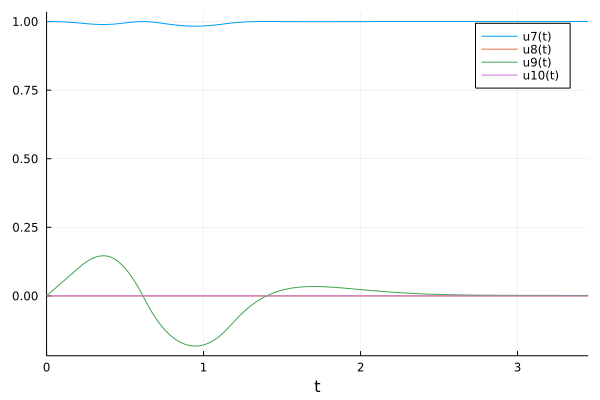

In [36]:
# plot(sol, vars=veh.id_r)
plot(sol, vars=veh.id_quat)
# plot(sol, vars=veh.id_ω)

# deviationAngle = map(q -> acosd(TVC.Utils.rotate(q, [0; 0; 1]) ⋅ [0; 0; 1]), eachcol(sol[veh.id_quat, :]))

# plot(sol.t, deviationAngle)